In [48]:
from numpy import *
from scipy.signal import fftconvolve

from scipy.io import wavfile
from os.path import join
from glob import glob

from itertools import islice, chain
from multiprocessing import Pool,cpu_count

from matplotlib.pyplot import *
%matplotlib inline
from IPython.display import Audio


def gaussian(x,mean=0.0,std=1.0) :
    """
    Calculate values of gaussian f(x) at x.
    f(x) = exp(-((x-mean)/std)**2) / sqrt(2*pi*std**2)

    Paramters
    ---------
    x : <numpy.ndarray>
        array of inputs to be passed to function
    mean : <float>
        mean of gaussian, defaults to zero
    std : <float>
        standard deviation of gaussian, defaults to one

    Returns
    ---------
    f(x) : <numpy.ndarray>
        array out outputs with same shape as inputs
    
    ---------
    """
    return exp(-((x-mean)/std)**2) / sqrt(2*pi*std**2)


def stft(signal,time,freq_cutoff=1e3,n_freq=500) :
    """
    Perform a shoft-time fourier transform with a window function
    given by the default parameters specified in MusicNet
    https://en.wikipedia.org/wiki/Short-time_Fourier_transform

    Paramters
    ---------
    signal : <numpy.ndarray>
        array of shape length n_points of a single-channel signal
        
    time : <numpy.ndarray>
        one dimensional array of timepoints at which signal was sampled
        
    freq : <numpy.ndarray>
        one dimensional array of freqencies to evaluate; defaults to all
        up to the nyquist frequency, at the limiting resolution.

    Returns
    ---------
    time,frequency,stft : <numpy.ndarray>,<numpy.ndarray>,<numpy.ndarray>
        time and frequency mesh aligned with stft spectorgram
    
    ---------
    """
    
    # getting frequency-time grid
    dt = mean(gradient(time))
    f_nyquist = 0.5/dt

    freq = linspace(0,freq_cutoff,int(n_freq))
    assert amax(freq) <= f_nyquist,'maximal frequency {}Hz must be less than nyquist {}Hz'.format(
        amax(freq),f_nyquist)
    
    # construct window function
    window = array(2048*[1])
    print window.size
    
    # multithreaded batched fftconvolve
    pool = Pool(cpu_count())
    results = []

    batch_size = freq.size/(10*cpu_count())+1
    for freq_batch in batch(freq,batch_size) :

        results += [
            pool.apply_async(
                fftconvolvebatch, args=(signal,time,freq_batch,window)) ]
    
    # wait for threads to finish
    pool.close()
    pool.join()
    
    # collect and return results
    results = vstack([ array(result.get()) for result in results ])
    time_grid,freq_grid = meshgrid(time,freq,copy=False)
    return time_grid,freq_grid,results


def fftconvolvebatch(signal,time,freq_batch,window,mode='same') :
    """
    Batch compute <scipy.signal.fftconvolve>;
    see its docstring for further details
    
    Paramters
    ---------
    signal_batch : [ <numpy.ndarray> ... <numpy.ndarray> ]
        list of one dimensional arrays of length n_points to convolve
        
    window : <numpy.ndarray>
        one dimensional array to perform convolution with
    
    Returns
    ---------
    results : [ <numpy.ndarray> ... <numpy.ndarray> ]
        results of <scipy.signal.fftconvolve> for batch
    
    ---------
    """
    
    results = []
    for freq in freq_batch :
        results += [ fftconvolve(signal*exp(-2j*pi*time*freq),window,mode) ]
        
    return results


def batch(l, n):
    """Yield successive n-sized batches from array"""
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def load(sample_id) :
    """Load (label,datum) pair given sample_id"""
    
    # load and parse data
    audio_path,label_path = glob(join('/','datadrive','musicnet','*','*',str(sample_id)+'.*'))
    start,end,inst,note,_,_,_ = genfromtxt(label_path,dtype=str,delimiter=',',skip_header=1).T
    
    sample_freq,audio = wavfile.read(audio_path)
    time = linspace(0,audio.size/float(sample_freq),audio.size)
    
    return audio,time, start,end,inst,note

In [49]:
x,t, start,end,inst,note = load('1727')
chop = 500000

x,t = x[:chop],t[:chop]
Audio(x,rate=44100)

In [42]:
%time time,freq,ft = stft(x,t)

2048
CPU times: user 4.51 s, sys: 12.9 s, total: 17.4 s
Wall time: 23.3 s


TypeError: float() argument must be a string or a number

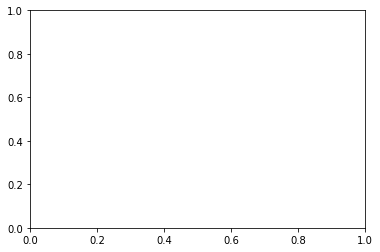

In [50]:
spectrogram = abs(ft)
contourf(time,freq,spectrogram,cmap='RdPu',vmin=0)

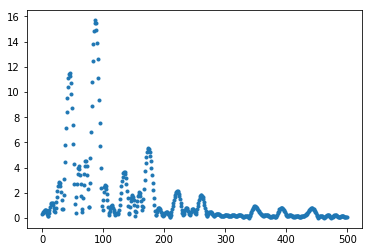

In [46]:
plot(spectrogram[:,500000/12],'.')

In [47]:
spectrogram.shape

(500, 500000)

In [51]:
    # wite out labels in intervaltrees for fast access
    def process_labels(self, path):
        trees = dict()
        for item in os.listdir(os.path.join(self.root,path)):
            if not item.endswith('.csv'): continue
            uid = int(item[:-4])
            tree = IntervalTree()
            with open(os.path.join(self.root,path,item), 'rb') as f:
                reader = csv.DictReader(f, delimiter=',')
                for label in reader:
                    start_time = int(label['start_time'])
                    end_time = int(label['end_time'])
                    instrument = int(label['instrument'])
                    note = int(label['note'])
                    start_beat = float(label['start_beat'])
                    end_beat = float(label['end_beat'])
                    note_value = label['note_value']
                    tree[start_time:end_time] = (instrument,note,start_beat,end_beat,note_value)
            trees[uid] = tree
        return trees